In [116]:
from importlib import reload
from dotenv import load_dotenv; load_dotenv();
import matplotlib.pyplot as plt
from tabulate import tabulate
from scipy.optimize import curve_fit

import librun
import libstop
from libdatasets import *
from libadversarial import uncertainty_stop
from passive import run_passive
from libstop import rank_stop_conds
from matrices import *

In [117]:
import passive; reload(passive); from passive import run_passive

In [118]:
import libdatasets
def lmbda(matrix, runs=(0,9)):
    results = librun.run(matrix, force_cache=True, fragment_run_start=runs[0], fragment_run_end=runs[1])
    results_plots = [result[0] for result in results]
    classifiers = [result[1] for result in results]
    classifiers = [clf for clf in classifiers]
    passive_results = run_passive(matrix['datasets'], range(10), matrix['models'][0])
    
    yield ["Dataset", "1k accuracy", "Average gain", "Gain standard Error", "Instances", "Gain per 1000", "Gain exp"]
    for config, _results in results_plots:
        X,y = getattr(libdatasets, config.dataset_name)(None)
        
        p = passive_results[config.dataset_name]
        diffs = []
        onek = []
        exp = []
        for i, run in enumerate(config.runs):
            x = _results[i].x
            accuracy = _results[i].accuracy_score
            
            onek.append([accuracy.iloc[-1]])
            diffs.append(p[run][0]-accuracy.iloc[-1])
            
            x = [*x, int(X.shape[0]/2-1000)]
            y = [*accuracy, p[run][0]]
            
            def func(x, A, B, C, D):
                return A*np.log(B*(x-D))-C*x
            
            #fit = curve_fit(func, x, y, [1/10, 4, 0.0000001, 10])
            fit = np.polyfit(x, y, 5)
            #print(fit)
            exp.append(np.polyval(fit, 2000))
            
            plt.figure()
            plt.plot(x[:-1], y[:-1])
            plt.plot(np.arange(x[0], 2000, 100), np.polyval(fit, np.arange(x[0], 2000, 100)))
        
        yield [config.dataset_name, np.mean(onek), np.mean(diffs), np.sqrt(np.var(diffs)), int(X.shape[0]/2-1000), 1000*np.mean(diffs)/(X.shape[0]/2), np.mean(exp)]

In [255]:
def fit_constrained(x, y):
    def polynomial(p, x):
        return p[0]+p[1]*x+p[2]*x**2+p[3]*x**3

    def constraint_1st_der(p):
        return p[1]+2*p[2]*x+3*p[3]*x**2
    
    def constraint_start_pt(p):
        return polynomial(p,x[-1])-y[-1]

    def objective(p):
        return ((polynomial(p, x)-y)**2).sum()


    cons = (dict(type='ineq', fun=constraint_1st_der), dict(type='eq', fun=constraint_start_pt))
    res = scipy.optimize.minimize(objective, x0=np.array([ 0,1,0,0]), method='SLSQP', constraints=cons)
    print(res)
    return lambda x: polynomial(res.x, x)

     fun: 161000038352.1019
     jac: array([9.01120000e+05, 3.22000931e+11, 1.29548059e+17, 6.22003882e+25])
 message: 'Inequality constraints incompatible'
    nfev: 5
     nit: 1
    njev: 1
  status: 4
 success: False
       x: array([0., 1., 0., 0.])
[ 4.79919721e-12 -1.93140473e-06  2.38169413e-03  4.50778054e-01]


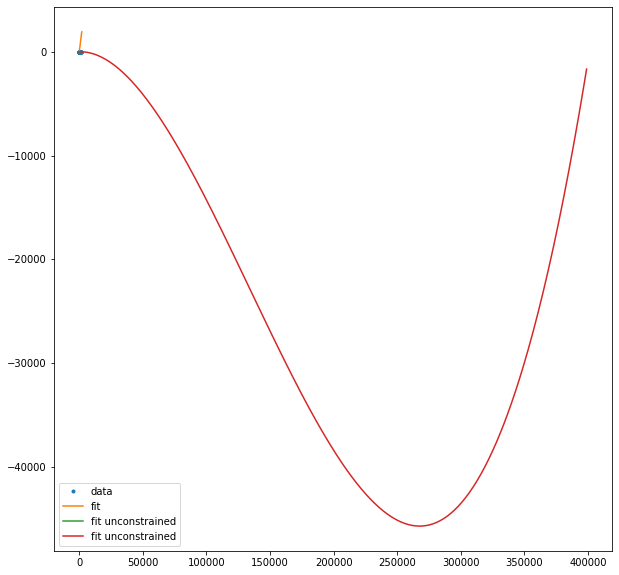

In [259]:
x = np.array([10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0, 110.0, 120.0, 130.0, 140.0, 150.0, 160.0, 170.0, 180.0, 190.0, 200.0, 210.0, 220.0, 230.0, 240.0, 250.0, 260.0, 270.0, 280.0, 290.0, 300.0, 310.0, 320.0, 330.0, 340.0, 350.0, 360.0, 370.0, 380.0, 390.0, 400.0, 410.0, 420.0, 430.0, 440.0, 450.0, 460.0, 470.0, 480.0, 490.0, 500.0, 510.0, 520.0, 530.0, 540.0, 550.0, 560.0, 570.0, 580.0, 590.0, 600.0, 610.0, 620.0, 630.0, 640.0, 650.0, 660.0, 670.0, 680.0, 690.0, 700.0, 710.0, 720.0, 730.0, 740.0, 750.0, 760.0, 770.0, 780.0, 790.0, 800.0, 810.0, 820.0, 830.0, 840.0, 850.0, 860.0, 870.0, 880.0, 890.0, 900.0, 910.0, 920.0, 930.0, 940.0, 950.0, 960.0, 970.0, 980.0, 990.0, 1000.0, 401207] )
y = np.array([0.4743925391651562, 0.4745267983898838, 0.5012319527009724, 0.4996382459778174, 0.5172386358268255, 0.4872366716640933, 0.5201276954404076, 0.5590703294572198, 0.6399639986375175, 0.6369680289005413, 0.6520622465546349, 0.7308102544212308, 0.7434132175720463, 0.7648549130174264, 0.8182403588202095, 0.8315941791167235, 0.8381977439477681, 0.8538712652937418, 0.8559373655853827, 0.8652186560651605, 0.8658228225764345, 0.867108230339104, 0.8687168547538954, 0.8713175056625071, 0.8720434999888117, 0.875089195364576, 0.8767574905459129, 0.8781672124055524, 0.881352139569923, 0.8810537857371951, 0.8804893997369514, 0.8813546258518623, 0.8825629588744104, 0.8840000298353833, 0.8852207942676283, 0.885118856708113, 0.8835674167779278, 0.8861979030698123, 0.8857031329638718, 0.8862749778099337, 0.8870233486736929, 0.8874136949381786, 0.888244113105938, 0.8875802758281184, 0.8865310648496918, 0.8879929986300586, 0.8887413694938179, 0.8890819901195156, 0.8896289721461834, 0.8891491197318794, 0.8894002342077587, 0.8896414035558804, 0.8901610364812149, 0.8893082417760009, 0.8896712389391532, 0.8938581377251017, 0.8945891046152852, 0.8952081888181956, 0.89539714624559, 0.8965905615765016, 0.8977516552422011, 0.8978511065197772, 0.8983185275243842, 0.8984005748283844, 0.8988157839122641, 0.8986939560972335, 0.8983707394451116, 0.8986293127668091, 0.899226020432265, 0.8993006088904469, 0.8986516893042638, 0.8995691273399021, 0.9001857252608731, 0.9009415549704506, 0.9008868567677838, 0.9013468189265726, 0.9021076212000289, 0.9019758482572406, 0.9029952238523944, 0.9034502134473044, 0.9034178917820924, 0.9037858615091234, 0.9041612900819728, 0.9044720753243976, 0.9045516363464584, 0.9048151822320348, 0.9044173771217308, 0.9042731727692456, 0.9043353298177308, 0.9041687489277908, 0.9050215436330048, 0.9049121472276712, 0.9046336836504586, 0.9046958406989436, 0.9047579977474286, 0.9045789854477918, 0.9049295512012472, 0.904872366716641, 0.9058544480827035, 0.9058718520562796, 0.9516293848689854])

# Custom function curve fit
#def func(x, k, A, B, C, base, c, d):
#    return C*(A+(1-A)*np.power(base, -k/(x+B), dtype=np.double)+c*x+d*x**2)
#x0 = [70, y[0]-0.1, -10, y[-1], 1.6, 0.000001, -0.00000000001]
#fit = curve_fit(func, x, y, x0)

# Polynomial fit
w = np.full(len(y), 1e-3)
w[-1] = 10.0
w[0] = 1.0
w[-2] = 1.0
w[20] = 1.0
fit = np.polyfit(x, y, 3, w=w)

# Constrainted polynomial fit
poly = fit_constrained(x, y)

# Cubic spline
#cs = scipy.interpolate.CubicSpline([x[0], x[20], x[-2], x[-1]], [y[0], y[20], y[-2], y[-1]], bc_type=('not-a-knot', 'clamped'))
#cs = scipy.interpolate.CubicSpline(x, y, bc_type=('not-a-knot', 'clamped'))

print(fit)

plt.figure(figsize=(10,10))
plt.plot(x[:-1],y[:-1], ls='', marker='.', label='data')

#plt.plot(np.arange(x[0], 2000, 100), cs(np.arange(x[0], 2000, 100)), label='Spline')

#plt.plot(np.arange(x[0], 2000, 100), func(np.arange(x[0], 2000, 100), *x0), label='initial')
#plt.plot(np.arange(x[0], 2000, 100), func(np.arange(x[0], 2000, 100), *fit[0]), label='fit')
plt.plot(np.arange(x[0], 2000, 100), poly(np.arange(x[0], 2000, 100)), label='fit')

plt.plot(np.arange(x[0], 2000, 100), np.polyval(fit, np.arange(x[0], 2000, 100)), label='fit unconstrained')
plt.plot(np.arange(x[0], 400000, 1000), np.polyval(fit, np.arange(x[0], 400000, 1000)), label='fit unconstrained')

plt.legend();

**1k accuracy**

The accuracy after 1000 instances (our current stop point).

**Average gain**

The accuracy gain from running to completion (all instances excluding test set)

**Gain Standard Error*

The standard error of the accuracy gain (based on multiple runs)

**Instances**

The number of untrained instances left excluding the test set but not considering any reserve (our current reserve is 500).

**Gain per 1000**

*Estimated* accuracy gain if another 1000 instances were labelled. The first 1000 are likely to have a slightly higher gain than this figure with subsequent instances offering diminishing returns.

## SVM

['/home/zac/.cache/pypoetry/virtualenvs/research-vDwbEF2m-py3.8/lib/python3.8/site-packages/ipykernel_launcher.py', '-f', '/home/zac/.local/share/jupyter/runtime/kernel-a7676e9c-8dcb-4a41-9daf-d4bb0dce12fa.json']


Experiment:   0%|          | 0/9 [00:00<?, ?it/s]

<ipython-input-118-8ee548c30488>:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


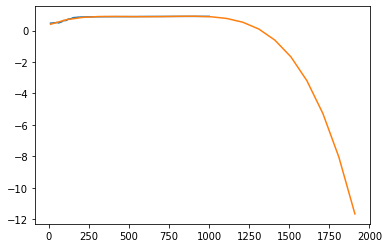

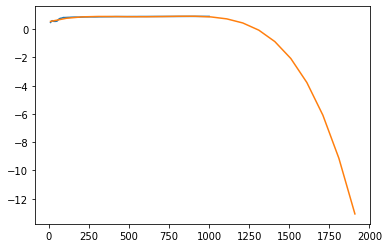

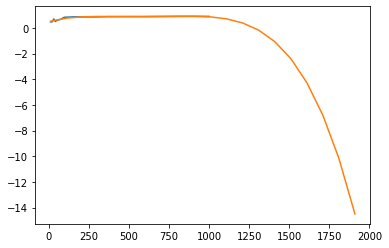

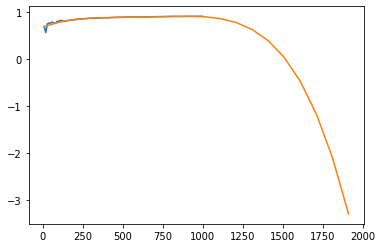

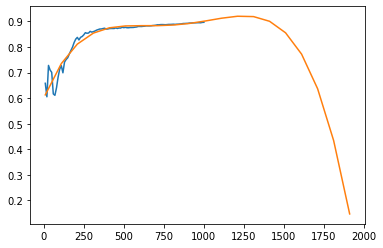

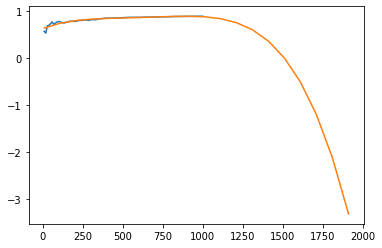

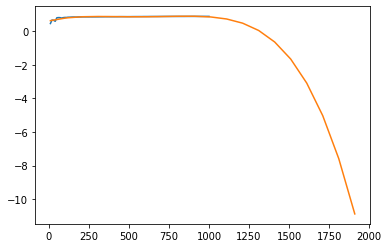

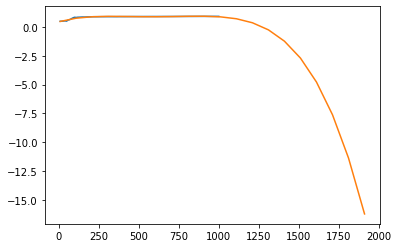

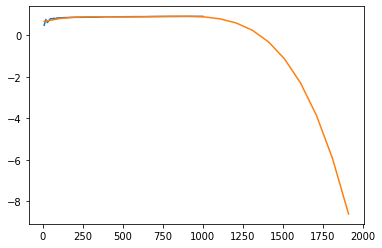

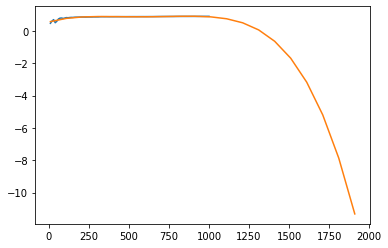

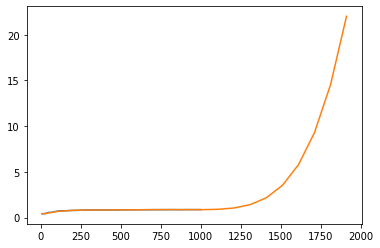

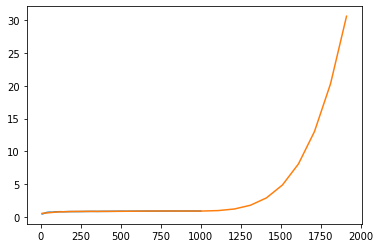

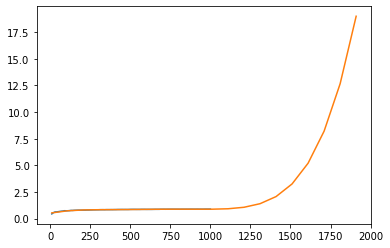

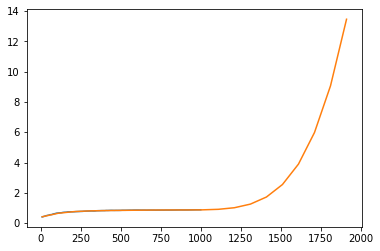

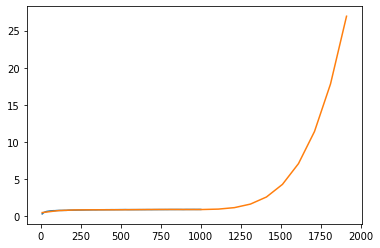

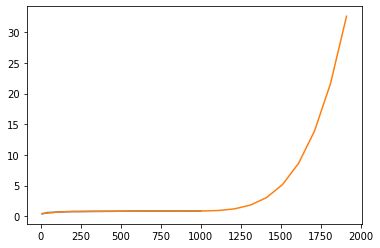

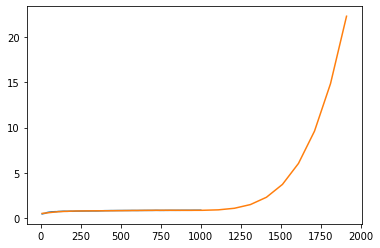

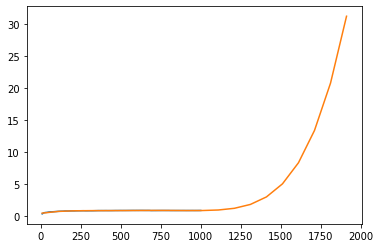

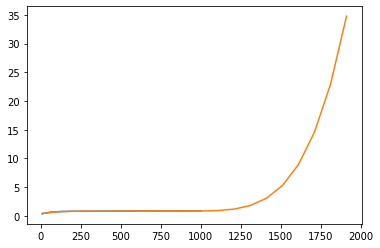

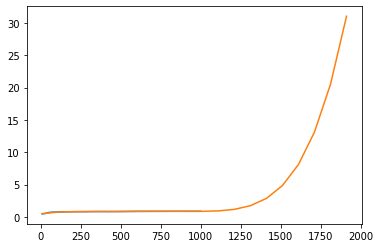

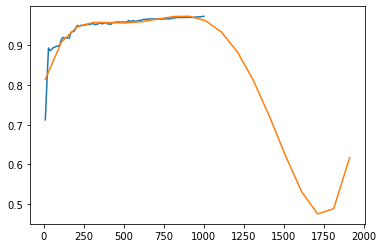

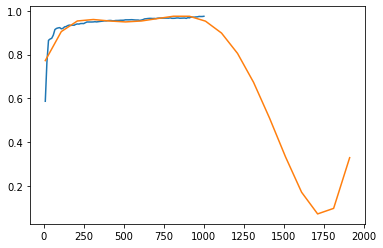

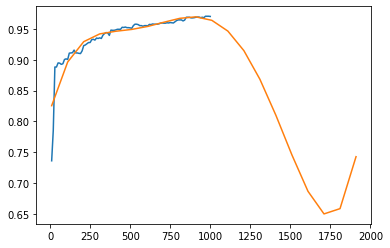

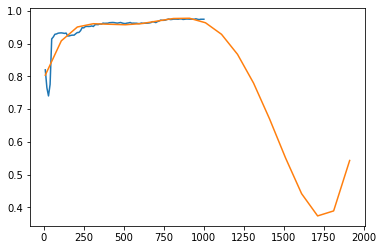

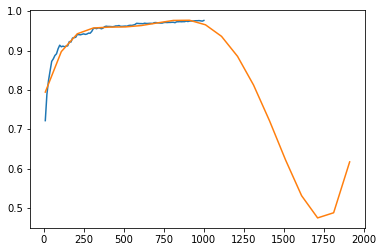

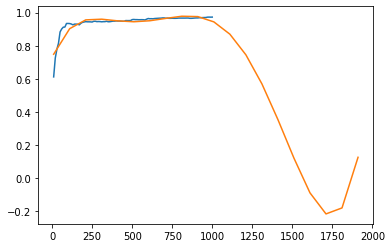

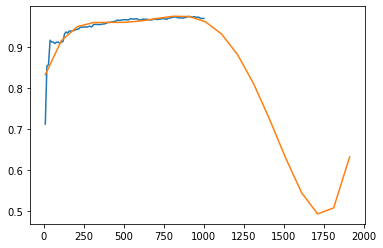

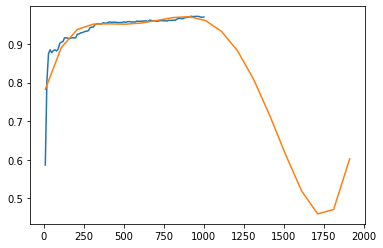

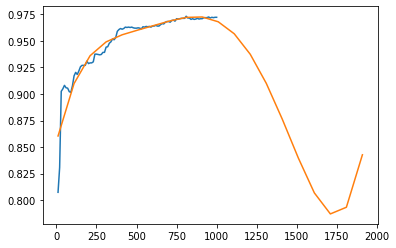

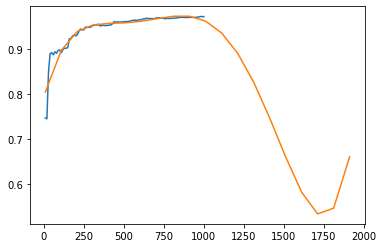

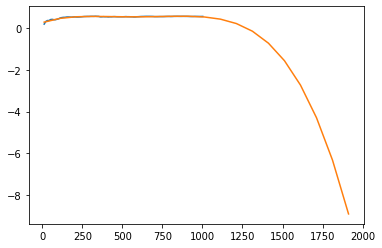

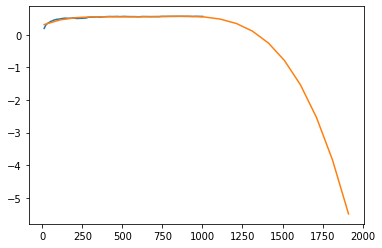

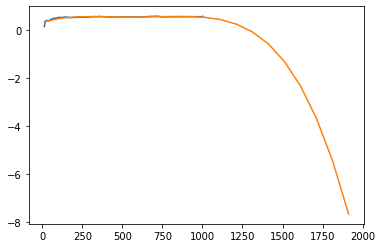

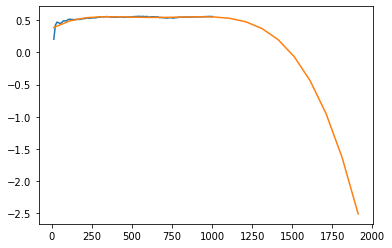

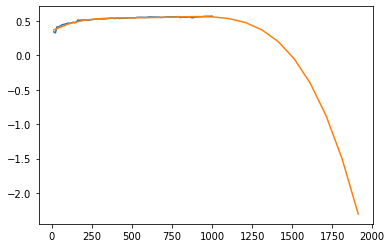

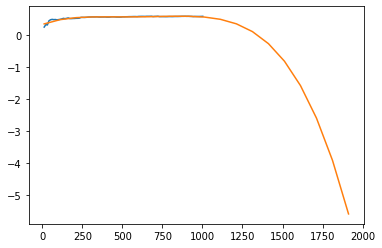

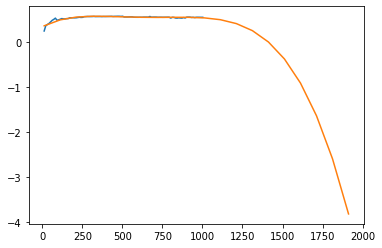

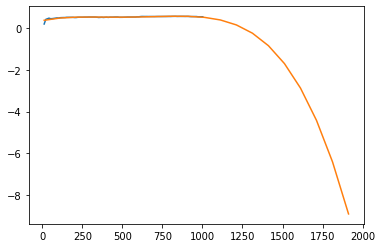

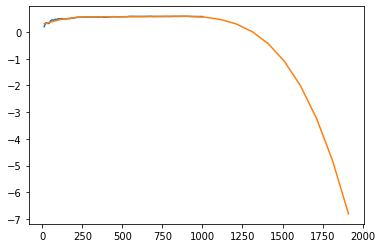

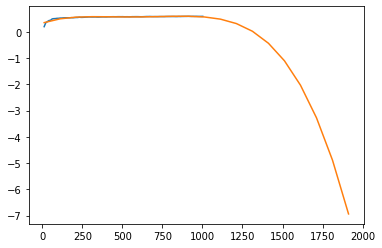

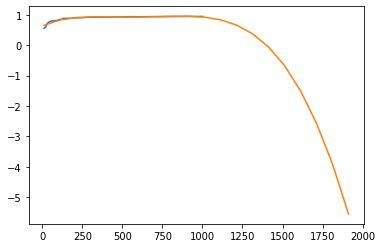

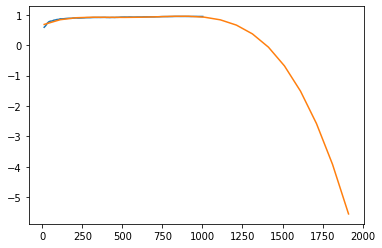

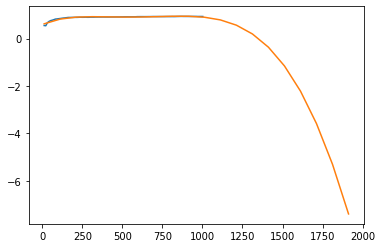

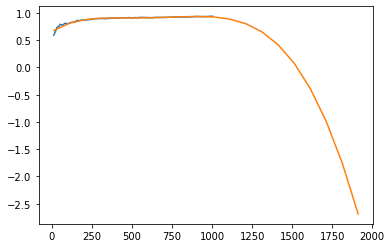

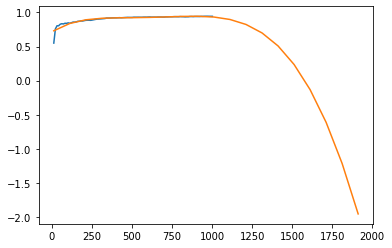

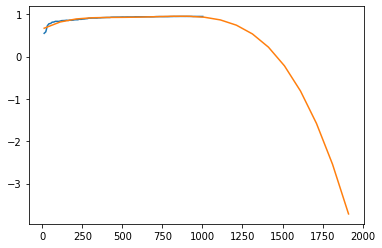

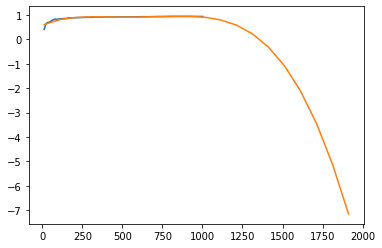

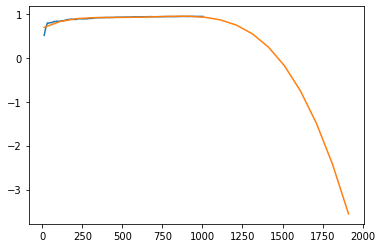

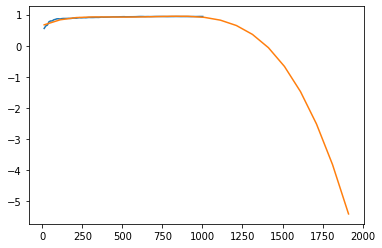

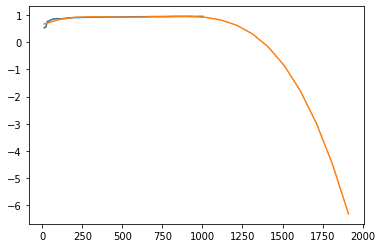

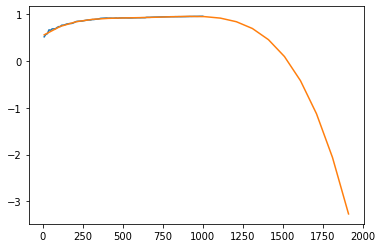

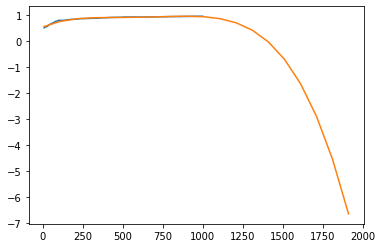

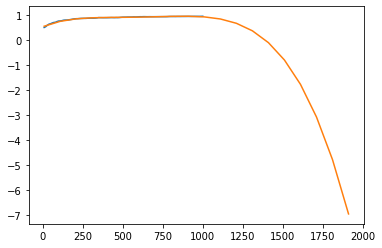

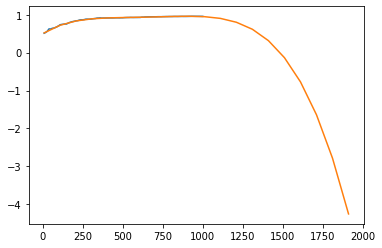

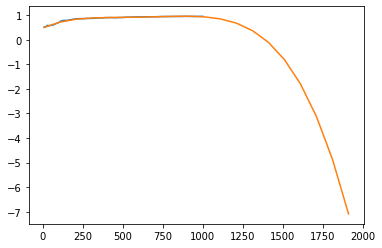

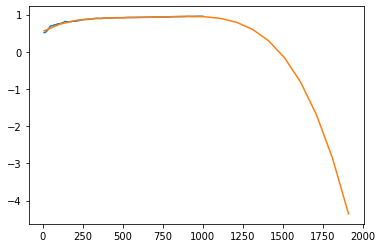

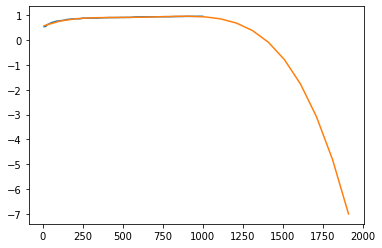

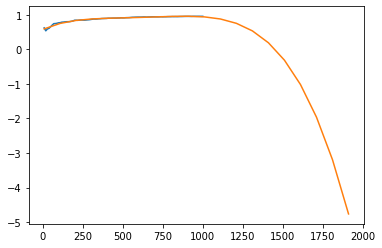

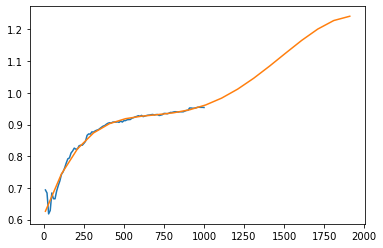

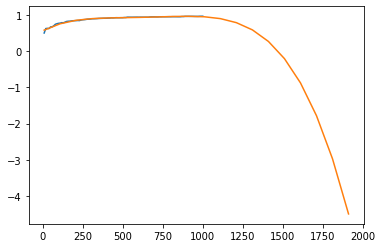

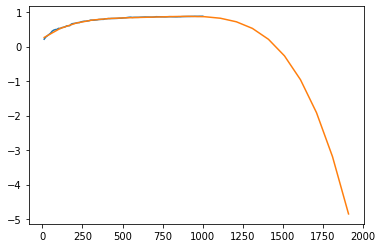

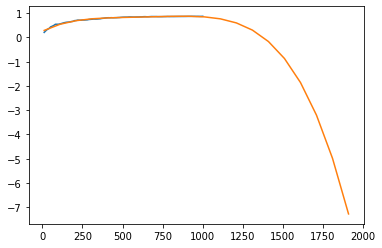

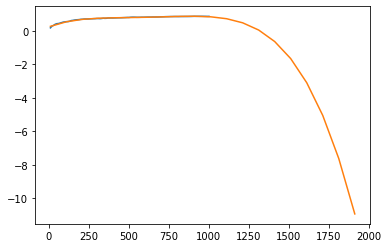

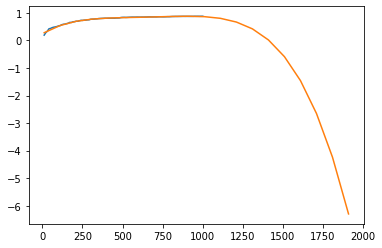

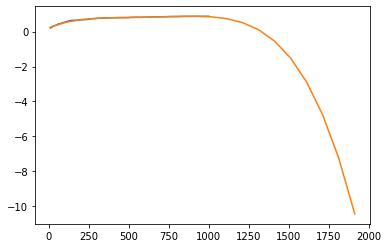

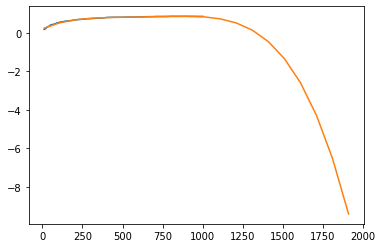

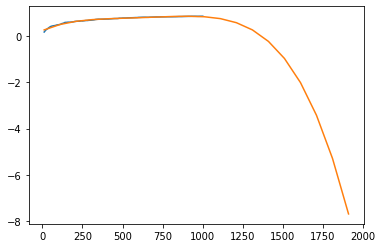

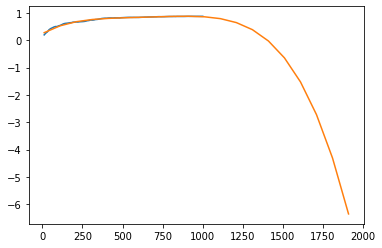

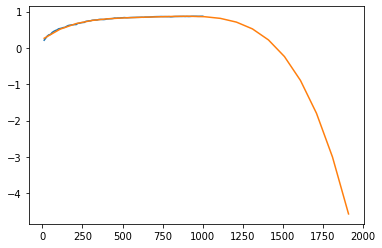

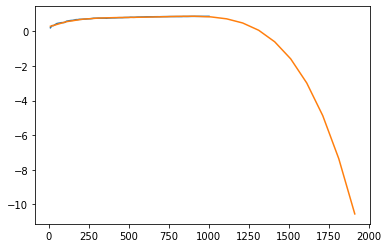

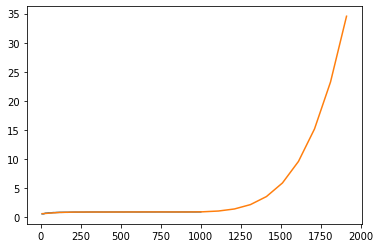

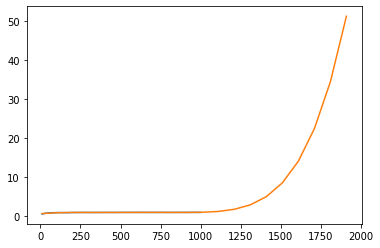

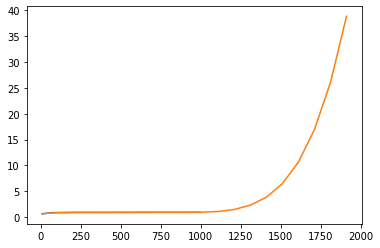

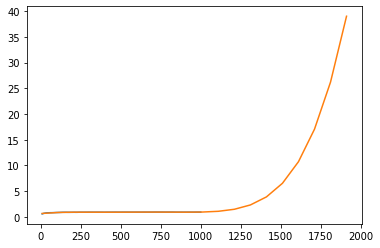

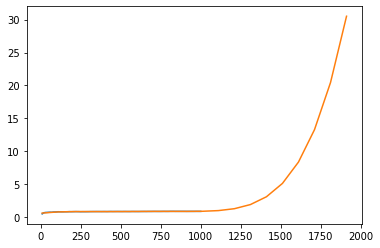

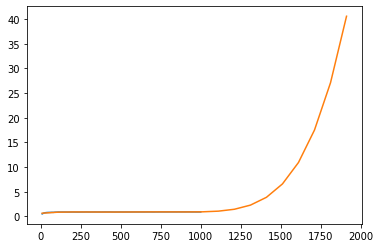

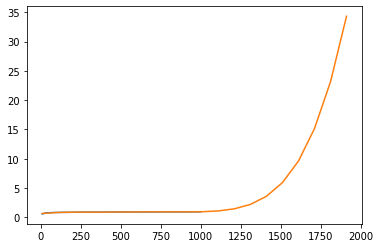

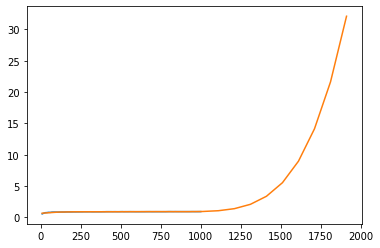

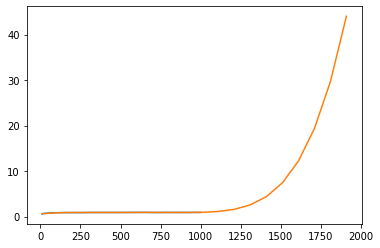

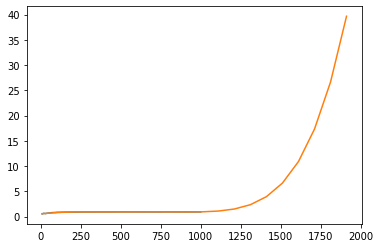

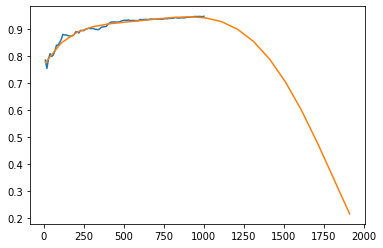

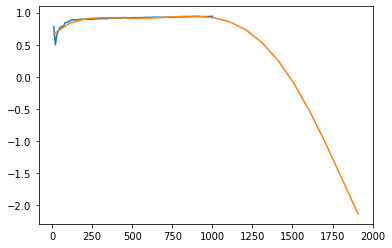

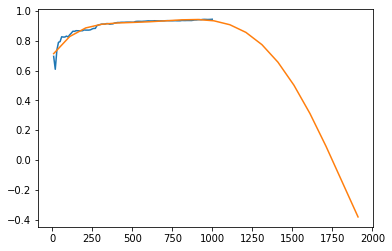

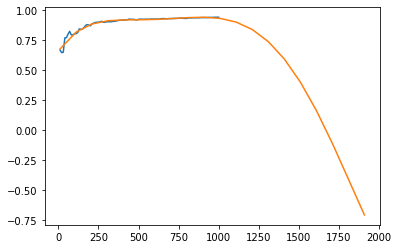

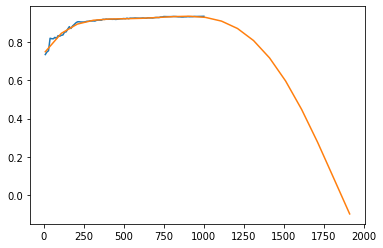

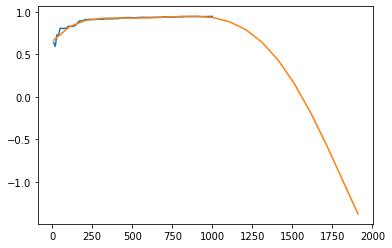

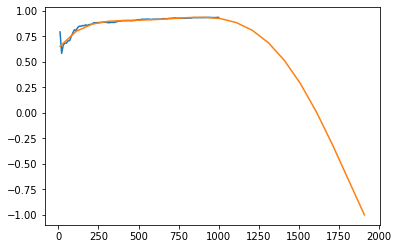

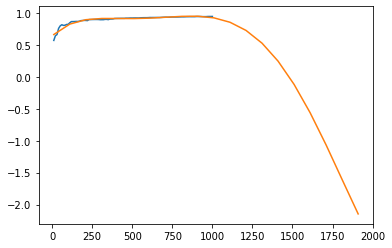

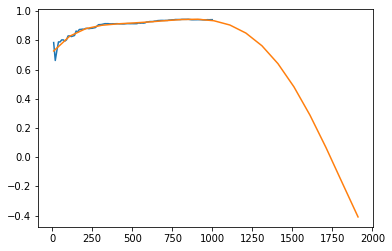

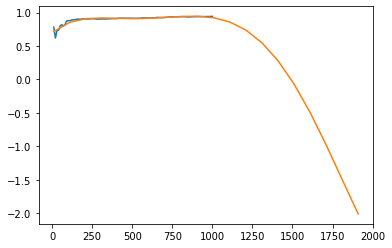

In [120]:
data = list(lmbda(BASE))

In [64]:
print(tabulate(data[1:], headers=data[0], floatfmt=".1%", tablefmt="fancy_grid"))

╒══════════════╤═══════════════╤════════════════╤═══════════════════════╤═════════════╤═════════════════╤════════════╕
│ Dataset      │   1k accuracy │   Average gain │   Gain standard Error │   Instances │   Gain per 1000 │   Gain exp │
╞══════════════╪═══════════════╪════════════════╪═══════════════════════╪═════════════╪═════════════════╪════════════╡
│ rcv1         │         90.2% │           5.0% │                  0.3% │      401207 │            0.0% │      89.8% │
├──────────────┼───────────────┼────────────────┼───────────────────────┼─────────────┼─────────────────┼────────────┤
│ webkb        │         87.4% │           1.9% │                  1.1% │        1099 │            0.9% │      89.8% │
├──────────────┼───────────────┼────────────────┼───────────────────────┼─────────────┼─────────────────┼────────────┤
│ spamassassin │         97.3% │           1.1% │                  0.2% │        2025 │            0.4% │      89.8% │
├──────────────┼───────────────┼────────────────

## Random forest

In [34]:
data = list(lmbda(RANDOM_FOREST))

['/home/zac/.cache/pypoetry/virtualenvs/research-vDwbEF2m-py3.8/lib/python3.8/site-packages/ipykernel_launcher.py', '-f', '/home/zac/.local/share/jupyter/runtime/kernel-a7676e9c-8dcb-4a41-9daf-d4bb0dce12fa.json']


Experiment:   0%|          | 0/9 [00:00<?, ?it/s]

In [35]:
print(tabulate(data[1:], headers=data[0], floatfmt=".1%", tablefmt="fancy_grid"))

╒══════════════╤═══════════════╤════════════════╤═══════════════════════╤═════════════╤═════════════════╕
│ Dataset      │   1k accuracy │   Average gain │   Gain standard Error │   Instances │   Gain per 1000 │
╞══════════════╪═══════════════╪════════════════╪═══════════════════════╪═════════════╪═════════════════╡
│ rcv1         │         87.6% │           7.3% │                  0.7% │      401207 │            0.0% │
├──────────────┼───────────────┼────────────────┼───────────────────────┼─────────────┼─────────────────┤
│ webkb        │         85.7% │           3.1% │                  0.9% │        1099 │            1.5% │
├──────────────┼───────────────┼────────────────┼───────────────────────┼─────────────┼─────────────────┤
│ spamassassin │         96.2% │           1.1% │                  0.3% │        2025 │            0.4% │
├──────────────┼───────────────┼────────────────┼───────────────────────┼─────────────┼─────────────────┤
│ avila        │         77.6% │          20.9

2-3% accuracy left

## Neural Net

In [24]:
data = list(lmbda(NEURAL_NET, runs=(0,1)))

['/home/zac/.cache/pypoetry/virtualenvs/research-vDwbEF2m-py3.8/lib/python3.8/site-packages/ipykernel_launcher.py', '-f', '/home/zac/.local/share/jupyter/runtime/kernel-a7676e9c-8dcb-4a41-9daf-d4bb0dce12fa.json']


Experiment:   0%|          | 0/9 [00:00<?, ?it/s]

Exception: Cache file '/home/zac/out/webkb__none__uncertainty__neural-network__dataset_size=1000__labelled_size=10__test_size=0.5__n_runs=10__ret_classifiers=True__ensure_y=True__stop_info=True__aggregate=False__stop_function=len1000__pool_subsample=1000.csv' not found

In [21]:
print(tabulate(data[1:], headers=data[0], floatfmt=".1%", tablefmt="fancy_grid"))

╒══════════════╤═══════════════╤════════════════╤═══════════════════════╤═════════════╤═════════════════╕
│ Dataset      │   1k accuracy │   Average gain │   Gain standard Error │   Instances │   Gain per 1000 │
╞══════════════╪═══════════════╪════════════════╪═══════════════════════╪═════════════╪═════════════════╡
│ rcv1         │         87.6% │           7.6% │                  0.7% │      401207 │            0.0% │
├──────────────┼───────────────┼────────────────┼───────────────────────┼─────────────┼─────────────────┤
│ webkb        │         85.7% │           3.6% │                  1.1% │        1099 │            1.7% │
├──────────────┼───────────────┼────────────────┼───────────────────────┼─────────────┼─────────────────┤
│ spamassassin │         96.2% │           2.2% │                  0.4% │        2025 │            0.7% │
├──────────────┼───────────────┼────────────────┼───────────────────────┼─────────────┼─────────────────┤
│ avila        │         77.6% │         -22.0

## Labelled 100

In [25]:
data = list(lmbda(LABELLED100))

['/home/zac/.cache/pypoetry/virtualenvs/research-vDwbEF2m-py3.8/lib/python3.8/site-packages/ipykernel_launcher.py', '-f', '/home/zac/.local/share/jupyter/runtime/kernel-a7676e9c-8dcb-4a41-9daf-d4bb0dce12fa.json']


Experiment:   0%|          | 0/9 [00:00<?, ?it/s]

Failed to open compressed store /home/zac/out/classifiers/rcv1__none__uncertainty__svm-linear__dataset_size=1000__labelled_size=100__test_size=0.5__n_runs=10__ret_classifiers=True__ensure_y=True__stop_info=True__aggregate=False__stop_function=len1000__pool_subsample=1000_6.zip


FileNotFoundError: [Errno 2] No such file or directory: '/home/zac/out/classifiers/rcv1__none__uncertainty__svm-linear__dataset_size=1000__labelled_size=100__test_size=0.5__n_runs=10__ret_classifiers=True__ensure_y=True__stop_info=True__aggregate=False__stop_function=len1000__pool_subsample=1000_6.zip'

In [21]:
print(tabulate(data[1:], headers=data[0], floatfmt=".1%", tablefmt="fancy_grid"))

╒══════════════╤═══════════════╤════════════════╤═══════════════════════╤═════════════╤═════════════════╕
│ Dataset      │   1k accuracy │   Average gain │   Gain standard Error │   Instances │   Gain per 1000 │
╞══════════════╪═══════════════╪════════════════╪═══════════════════════╪═════════════╪═════════════════╡
│ rcv1         │         87.6% │           7.6% │                  0.7% │      401207 │            0.0% │
├──────────────┼───────────────┼────────────────┼───────────────────────┼─────────────┼─────────────────┤
│ webkb        │         85.7% │           3.6% │                  1.1% │        1099 │            1.7% │
├──────────────┼───────────────┼────────────────┼───────────────────────┼─────────────┼─────────────────┤
│ spamassassin │         96.2% │           2.2% │                  0.4% │        2025 │            0.7% │
├──────────────┼───────────────┼────────────────┼───────────────────────┼─────────────┼─────────────────┤
│ avila        │         77.6% │         -22.0

## Bias

In [36]:
data = list(lmbda(BIAS))

['/home/zac/.cache/pypoetry/virtualenvs/research-vDwbEF2m-py3.8/lib/python3.8/site-packages/ipykernel_launcher.py', '-f', '/home/zac/.local/share/jupyter/runtime/kernel-a7676e9c-8dcb-4a41-9daf-d4bb0dce12fa.json']


Experiment:   0%|          | 0/5 [00:00<?, ?it/s]

Exception: Cache file '/home/zac/out/avila__bias2-10__uncertainty__svm-linear__dataset_size=1000__labelled_size=10__test_size=0.5__n_runs=10__ret_classifiers=True__ensure_y=True__stop_info=True__aggregate=False__stop_function=len1000__pool_subsample=1000.csv' not found

In [ ]:
print(tabulate(data[1:], headers=data[0], floatfmt=".1%", tablefmt="fancy_grid"))

## Unbalanced

In [37]:
data = list(lmbda(UNBALANCED))

['/home/zac/.cache/pypoetry/virtualenvs/research-vDwbEF2m-py3.8/lib/python3.8/site-packages/ipykernel_launcher.py', '-f', '/home/zac/.local/share/jupyter/runtime/kernel-a7676e9c-8dcb-4a41-9daf-d4bb0dce12fa.json']


Experiment:   0%|          | 0/3 [00:00<?, ?it/s]

Exception: Cache file '/home/zac/out/swarm__unbalanced2-70__uncertainty__svm-linear__dataset_size=1000__labelled_size=10__test_size=0.5__n_runs=10__ret_classifiers=True__ensure_y=True__stop_info=True__aggregate=False__stop_function=len1000__pool_subsample=1000.csv' not found

In [ ]:
print(tabulate(data[1:], headers=data[0], floatfmt=".1%", tablefmt="fancy_grid"))

## Noise

In [38]:
data = list(lmbda(NOISE))

NameError: name 'NOISE' is not defined

In [ ]:
print(tabulate(data[1:], headers=data[0], floatfmt=".1%", tablefmt="fancy_grid"))